In [62]:
import importlib
import numpy as np
from openai import OpenAI
import os
import pandas as pd
from dotenv import load_dotenv, find_dotenv
import json
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()

### Step 1: Prep Data

In [104]:
sp = pd.read_pickle('data/sp500_constituents.pkl')
fomc = pd.read_pickle('data/fomc_statements.pkl')
fomc = fomc.drop(columns='statement')
fomc = fomc.rename(columns={'cleaned_statement':'statement'})
fomc = fomc[fomc['date']>='2000-01-03'].reset_index(drop=True)
fomc = fomc[fomc['date'] <= '2024-01-01'].reset_index(drop=True)

### Step 2: Create Fine Tuned Model
<!-- - OpenAI documentation recommended to get prompts as good as possible on a model that is not fine tuned, and then once this is done, fine tune the model   -->
[Chat Completions Documentation](https://platform.openai.com/docs/guides/chat-completions/overview)   

Roles:
- System (optional): Sets the behavior of the assistant  
- User: provide requests or comments for the assistant to respond to  

In [105]:
# load nate key
_ = load_dotenv(find_dotenv())
api_key = os.environ.get('OPENAI_API_KEY') 
client = OpenAI(api_key=api_key)

response = client.files.create(
  file=open("data/train_data.jsonl", "rb"),
  purpose="fine-tune"
)

In [106]:
# file id
response.id

'file-RpBPBTrgTeTTIY4xwqXnC9IO'

In [107]:
# specified model to use in writeup
model = "gpt-3.5-turbo-0125"

fine_tune_response = client.fine_tuning.jobs.create(
  training_file=response.id,
  model=model
)

In [108]:
client.fine_tuning.jobs.list(limit=10)
fine_tune_response
# client.fine_tuning.jobs.retrieve(response.id)

FineTuningJob(id='ftjob-hyHdmqfKPCbDfDTOrBNoaOBV', created_at=1728187684, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-mlcW3CadBiACwaM4gyhnYXxH', result_files=[], seed=1774875622, status='validating_files', trained_tokens=None, training_file='file-RpBPBTrgTeTTIY4xwqXnC9IO', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [109]:
client.fine_tuning.jobs.retrieve("ftjob-Zdt8hsTrR0HZaEZEJ1ZEN603")

FineTuningJob(id='ftjob-Zdt8hsTrR0HZaEZEJ1ZEN603', created_at=1727583972, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal::ACg0wQ38', finished_at=1727584800, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-mlcW3CadBiACwaM4gyhnYXxH', result_files=['file-LkVL0M8MCUASnhq1QdqdXrT5'], seed=537148697, status='succeeded', trained_tokens=279411, training_file='file-dVRcwwwpHAzoQUKujEGazzAn', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

### Step 2: Fine Tune Model
<!-- - OpenAI documentation recommended to get prompts as good as possible on a model that is not fine tuned, and then once this is done, fine tune the model   -->
[Chat Completions Documentation](https://platform.openai.com/docs/guides/chat-completions/overview)   

Roles:
- System (optional): Sets the behavior of the assistant  
- User: provide requests or comments for the assistant to respond to  

In [110]:
# max_tokens: how many words gpt can output
# temperature: randomness. 0 has no randomness, 2 is totally random 

### Step 3: Craft Prompts for GICS Sectors

Strategy 2: Aims to have GPT forecast the best and worst performing sector over the next day

In [111]:
# use gpt to decide what sector to long/short
def construct_portfolio_by_sector(statement, date):
    messages = [
                {
                    "role": "system",
                        "content": f"""As of {date.strftime('%Y-%m-%d')}, you are a financial analyst specializing in 
                        interpreting FOMC statements to predict GICS sector returns in the stock market."""
                    },
                    {   
                        # system to describe what we are asking the
                        "role": "user",
                        "content": f"""Based on the FOMC statement released on {date.strftime('%Y-%m-%d')}, please identify:

                    - The sector that will have the highest returns over the next day.
                    - The sector that will have the lowest returns over the next day.

                    Provide your answer in the following format:

                    'long: sector, short: sector'

                    Recall the list of sector to choose from are:
                    'Energy', 'Materials', 'Industrials', 'Consumer Discretionary', 'Consumer Staples', 'Health Care',
                    'Financials', 'Information Technology', 'Communication Services', 'Utilities', 'Real Estate' 

                    Here is the FOMC Statement:
                    \"\"\"
                    {statement}
                    \"\"\"
                    """
                }
            ]
    
    # call the chat completions api using the client object
    response = client.chat.completions.create(
        # model="gpt-3.5-turbo-0125",  # model as specified in the writeup
        model = 'ft:gpt-3.5-turbo-0125:personal::ACg0wQ38', # fine tuned model (sucks rn)
        messages=messages,
        temperature=0,  # set temperature to 0 for deterministic output
        max_tokens=256  # limit the number of tokens to only capture the sentiment label
    )
    
    analysis = response.choices[0].message.content.strip()
    return analysis


### Step 4: Parse GPT Response
Creates columns for the sector to long and short according to the forecasts by GPT

In [112]:
def parse_sector_analysis(analysis):
    try:
        # find position of "long:" and "short:"
        long_part = analysis.split("long: ")[1].split(", short: ")[0].strip()
        short_part = analysis.split(", short: ")[1].strip()
        return long_part, short_part
    except (IndexError, AttributeError):
        print("Failed to parse GPT response as expected.")
        return "", ""


In [113]:
tqdm.pandas()  

# add cols of which group to long/short
def get_sectors(row):
    # run model to get prediction
    analysis = construct_portfolio_by_sector(row['statement'], row['date'])
    
    # parse results of analysis and retreive industry group names
    long_gics, short_gics = parse_sector_analysis(analysis)
    return pd.Series({'long': long_gics, 'short': short_gics})

# apply the function to each row
fomc[['long', 'short']] = fomc.progress_apply(get_sectors, axis=1)


100%|██████████| 159/159 [01:14<00:00,  2.13it/s]


In [114]:
fomc

,date,statement,long,short
0,2000-02-02,immediate release federal open market committe...,Consumer Discretionary,Energy
1,2000-03-21,immediate release federal open market committe...,Consumer Discretionary,Energy
2,2000-05-16,immediate release federal open market committe...,Consumer Discretionary,Energy
3,2000-06-28,immediate release federal open market committe...,Utilities,Information Technology
4,2000-08-22,immediate release federal open market committe...,Utilities,Information Technology
...,...,...,...,...
154,2023-06-14,recent indicators suggest economic activity co...,Real Estate,Energy
155,2023-07-26,recent indicators suggest economic activity ex...,Real Estate,Energy
156,2023-09-20,recent indicators suggest economic activity ex...,Real Estate,Energy
157,2023-11-01,recent indicators suggest economic activity ex...,Real Estate,Energy


In [115]:
sp

,date,permno,comnam,ticker,gvkey,ret,gsector,ggroup,gind,sector,industry,group
0,2000-01-03,64936,DOMINION RESOURCES INC VA,D,004029,-0.028662,55,5510,551030,Utilities,Multi-Utilities,Utilities
1,2000-01-03,24205,F P L GROUP INC,FPL,004517,-0.036496,55,5510,551010,Utilities,Electric Utilities,Utilities
2,2000-01-03,60441,MIRAGE RESORTS INC,MIR,005211,-0.028926,25,2530,253010,Consumer Discretionary,"Hotels, Restaurants & Leisure",Consumer Services
3,2000-01-03,45751,MARSH & MCLENNAN COS INC,MMC,007065,-0.011757,40,4030,403010,Financials,Insurance,Insurance
4,2000-01-03,76887,ALLIED WASTE INDUSTRIES INC,AW,022140,-0.042553,20,2020,202010,Industrials,Commercial Services & Supplies,Commercial & Professional Services
...,...,...,...,...,...,...,...,...,...,...,...,...
3021419,2023-12-29,87445,TELEDYNE TECHNOLOGIES,TDY,126721,0.004683,45,4520,452030,Information Technology,Communications Equipment,Technology Hardware & Equipment
3021420,2023-12-29,21792,CENTERPOINT ENERGY INC,CNP,005742,0.000350,55,5510,551030,Utilities,Multi-Utilities,Utilities
3021421,2023-12-29,13356,PHILLIPS 66,PSX,170841,0.002258,10,1010,101020,Energy,Energy Equipment & Services,Energy
3021422,2023-12-29,58819,ALLIANT ENERGY CORP,LNT,011554,-0.000390,55,5510,551010,Utilities,Electric Utilities,Utilities


### Step 5: Construct Portfolio

In [116]:
display(sp.columns)

print(f"Number of records without gics information: {sp['group'].isnull().sum()}")

Index(['date', 'permno', 'comnam', 'ticker', 'gvkey', 'ret', 'gsector',
       'ggroup', 'gind', 'sector', 'industry', 'group'],
      dtype='object')

Number of records without gics information: 0


In [117]:
fomc_test = fomc[fomc['date']>='2019-01-01'].reset_index(drop=True)
display(fomc_test['long'].value_counts())
display(fomc_test['short'].value_counts())

long
Real Estate               22
Utilities                  9
Consumer Discretionary     6
Energy                     2
Name: count, dtype: int64

short
Energy                    27
Information Technology     9
Utilities                  2
Real Estate                1
Name: count, dtype: int64

In [118]:
# for each date, get the stocks to short on long based on their GICS classification
portfolio_records = []

for idx, row in fomc_test.iterrows():
    date = row['date']
    long_gics = row['long']
    short_gics = row['short']
    
    if not long_gics and not short_gics:
        print(f'no stocks identified for {date}')
        continue
    
    # S&P constituents on date
    stocks_on_date = sp[sp['date'] == date]
    
    # stocks to long
    long_stocks = stocks_on_date[stocks_on_date['group'].isin([long_gics])]
    
    # stocks to short
    short_stocks = stocks_on_date[stocks_on_date['group'].isin([short_gics])]
    
    # record positions
    for permno in long_stocks['permno'].unique():
        portfolio_records.append({
            'date': date,
            'permno': permno,
            'position': 'long'
        })
    
    for permno in short_stocks['permno'].unique():
        portfolio_records.append({
            'date': date,
            'permno': permno,
            'position': 'short'
        })


In [119]:
# Each FOMC statement has the stocks to long and the stocks to short
df_portfolio = pd.DataFrame(portfolio_records)
df_portfolio

,date,permno,position
0,2019-01-30,18411,long
1,2019-01-30,23536,long
2,2019-01-30,21776,long
3,2019-01-30,44206,long
4,2019-01-30,24109,long
...,...,...,...
1642,2023-12-13,38156,short
1643,2023-12-13,13641,short
1644,2023-12-13,11850,short
1645,2023-12-13,34833,short


In [120]:
# merge on returns
df_positions = pd.merge(df_portfolio, sp[['date', 'permno', 'ret']], 
                        left_on=['date', 'permno'], right_on=['date', 'permno'], 
                        how='left')

df_positions.rename(columns={'ret': 'return'}, inplace=True)



In [121]:
df_positions

,date,permno,position,return
0,2019-01-30,18411,long,0.006095
1,2019-01-30,23536,long,0.004358
2,2019-01-30,23536,long,0.004358
3,2019-01-30,21776,long,0.009740
4,2019-01-30,44206,long,0.003415
...,...,...,...,...
1651,2023-12-13,38156,short,0.007265
1652,2023-12-13,13641,short,0.010684
1653,2023-12-13,11850,short,0.008873
1654,2023-12-13,34833,short,0.030063


In [122]:
# get next day returns (realized returns)

# calculate next trading day
df_positions['close_date'] = df_positions['date'] + pd.Timedelta(days=1)

df_positions = pd.merge(df_positions, sp[['date', 'permno', 'ret']], 
                        left_on=['close_date', 'permno'], right_on=['date', 'permno'], 
                        how='left', suffixes=('', '_next'))

df_positions.rename(columns={'ret': 'next_return'}, inplace=True)

# drop redundant date col
df_positions.drop(columns=['date_next'], inplace=True)




In [123]:
display(df_positions.isna().sum())

date           0
permno         0
position       0
return         0
close_date     0
next_return    0
dtype: int64

In [124]:
# drop positions with missing next day returns
df_positions.dropna(subset=['next_return'], inplace=True)

In [125]:
df_positions

,date,permno,position,return,close_date,next_return
0,2019-01-30,18411,long,0.006095,2019-01-31,0.015250
1,2019-01-30,23536,long,0.004358,2019-01-31,0.022256
2,2019-01-30,23536,long,0.004358,2019-01-31,0.022256
3,2019-01-30,23536,long,0.004358,2019-01-31,0.022256
4,2019-01-30,23536,long,0.004358,2019-01-31,0.022256
...,...,...,...,...,...,...
1669,2023-12-13,38156,short,0.007265,2023-12-14,0.000000
1670,2023-12-13,13641,short,0.010684,2023-12-14,0.026629
1671,2023-12-13,11850,short,0.008873,2023-12-14,0.026891
1672,2023-12-13,34833,short,0.030063,2023-12-14,0.026914


In [126]:
# get realized return (i.e. negate the shorts)
def calculate_position_return(row):
    if row['position'] == 'long':
        return row['next_return']
    elif row['position'] == 'short':
        return -row['next_return']
    else:
        return 0

df_positions['position_return'] = df_positions.apply(calculate_position_return, axis=1)


In [127]:
# get returns of the portfolio by day
# group by 'date' and calculate mean return to calculate returns per FOMC
df_portfolio_returns = df_positions.groupby('date')['position_return'].mean().reset_index()

df_portfolio_returns.sort_values('date', inplace=True)
df_portfolio_returns.reset_index(drop=True, inplace=True)

df_portfolio_returns

,date,position_return
0,2019-01-30,0.020589
1,2019-03-20,0.012458
2,2019-05-01,-0.001817
3,2019-06-19,0.006060
4,2019-07-31,0.010968
5,2019-09-18,0.003464
6,2019-10-30,0.004531
7,2019-12-11,-0.005438
8,2020-01-29,-0.002640
9,2020-04-29,-0.004609


In [128]:
# position daily returns
df_portfolio_returns['position_return'].describe()

count    39.000000
mean      0.001876
std       0.023231
min      -0.064952
25%      -0.007146
50%       0.000204
75%       0.008195
max       0.103960
Name: position_return, dtype: float64

In [129]:
df_portfolio_returns['ann_returns'] = (((1 + df_portfolio_returns['position_return']) ** 252) - 1)

In [130]:
df_portfolio_returns = df_portfolio_returns[df_portfolio_returns['date']>='2019-01-01']

In [131]:
df_portfolio_returns.drop(columns=['position_return']).to_csv('data/annualized_returns_test.csv')

In [132]:
df_portfolio_returns['cumulative_return'] = (1 + df_portfolio_returns['position_return']).cumprod()


In [133]:
# calculate average daily return, average vol, and sharpe
average_daily_return = df_portfolio_returns['position_return'].mean()
print(f"Average Daily Return: {average_daily_return * 100:.4f}%")

daily_volatility = df_portfolio_returns['position_return'].std()
print(f"Daily Volatility: {daily_volatility * 100:.4f}%")

sharpe_ratio = (average_daily_return / daily_volatility) * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Average Daily Return: 0.1876%
Daily Volatility: 2.3231%
Sharpe Ratio: 1.28


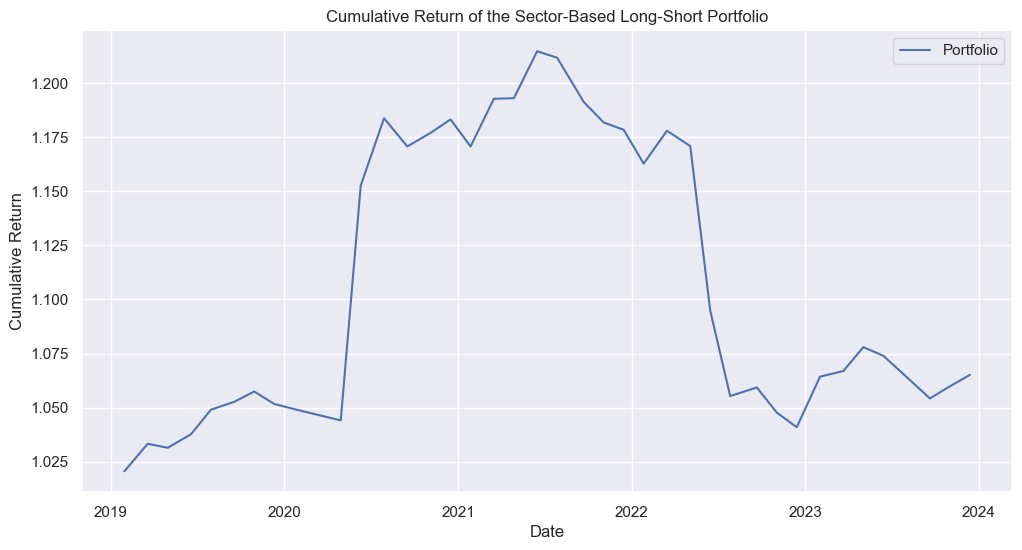

In [134]:
plt.figure(figsize=(12, 6))
plt.plot(df_portfolio_returns['date'], df_portfolio_returns['cumulative_return'], label='Portfolio')


plt.title('Cumulative Return of the Sector-Based Long-Short Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


In [149]:
test_df = pd.read_pickle('data/test_df.pkl')
#test_df = pd.read_pickle('data/train_df.pkl')
test_df = test_df.drop(columns=['statement'])
test_df = test_df.rename(columns={'strategy':'label'})
test_df.head()


,date,label
120,2019-01-30,"long: Communication Services, short: Energy"
121,2019-03-20,"long: Information Technology, short: Financials"
122,2019-05-01,"long: Health Care, short: Energy"
123,2019-06-19,"long: Energy, short: Communication Services"
124,2019-07-31,"long: Utilities, short: Energy"


In [152]:
def extract_long_short(df):
    # Split the 'strategy' column into 'long' and 'short'
    df['long_label'] = df['label'].str.extract(r'long: ([^,]+)')
    df['short_label'] = df['label'].str.extract(r'short: (.+)')
    return df


In [153]:
df = extract_long_short(test_df)
df = df.drop(columns='label')
df = pd.merge(df, fomc_test, on='date').drop(columns='statement')

In [154]:
def calculate_accuracy(df):
    total_rows = len(df)  # Total number of rows

    # Count correct long predictions
    correct_longs = (df['long_label'] == df['long']).sum()
    
    # Count correct short predictions
    correct_shorts = (df['short_label'] == df['short']).sum()
    
    # Calculate total correct labels (both long and short)
    total_correct = correct_longs + correct_shorts
    
    # Calculate fractions
    fraction_longs = correct_longs / total_rows
    fraction_shorts = correct_shorts / total_rows
    fraction_total = total_correct / (2 * total_rows)  # Multiply total_rows by 2 (since long and short are two predictions per row)
    
    # Create a DataFrame to store results
    accuracy_df = pd.DataFrame({
        'Correct Longs': [correct_longs],
        'Correct Shorts': [correct_shorts],
        'Total Correct': [total_correct],
        'Fraction Longs': [fraction_longs],
        'Fraction Shorts': [fraction_shorts],
        'Fraction Total': [fraction_total]
    })
    
    return accuracy_df

# Example usage
accuracy_df = calculate_accuracy(df)

In [156]:
accuracy_df

,Correct Longs,Correct Shorts,Total Correct,Fraction Longs,Fraction Shorts,Fraction Total
0,5,8,13,0.128205,0.205128,0.166667


In [54]:
# display(test_df['long_label'].value_counts())
# display(test_df['short_label'].value_counts())

In [55]:
# display(test_df['long_label'].value_counts())
# display(test_df['short_label'].value_counts())